# Object Detection 모델

- <span style='font-size:1.3em;font-weight:bold'>Object Detection = Localization + Classification</span>
    - **Object Detection** 은 이미지에 존재하는 Object(물체)들을 Bounding Box를 이용해 그 위치를 찾아내고(Localization) class를 분류(Classification)하는 작업이다.   
    - Deep learning 을 이용한 Object Detection 모델들은  One stage detector와 Two stage detector 두가지 방식이 있다.
        

## One stage vs Two Stage detector
- **One stage Detector**
    - Localization과 classification을 하나의 네트워크에서 처리한다. 
- **Two stage Detector**
    - Localization과 classification을 처리하는 모델을 따로 만들어서 각각 순차적으로 처리한다. 
    - 정확도가 높은 대신 속도가 느리다.  느리다는 단점 때문에 Real-Time Detection이 안된다.
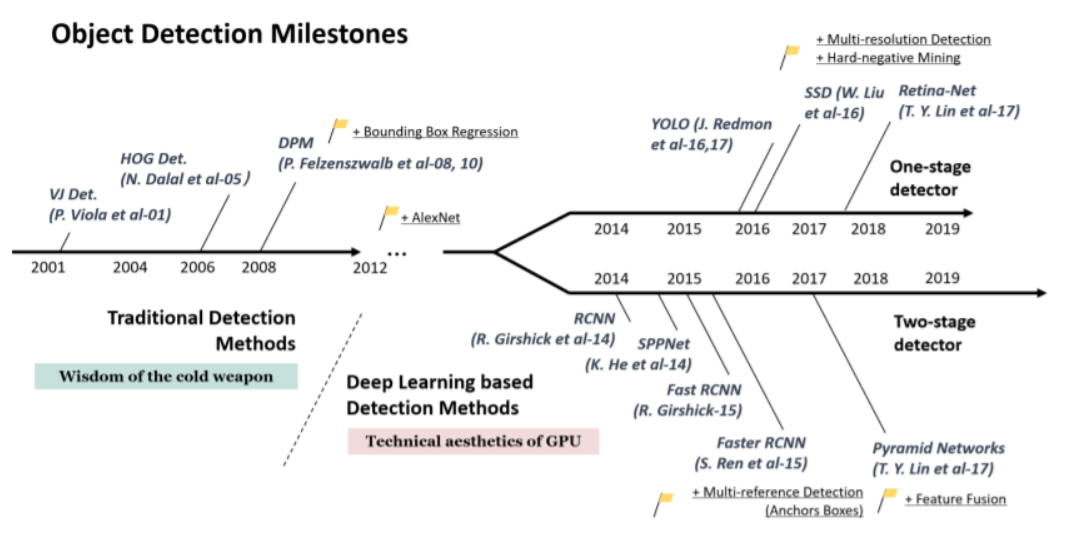
<center><font size=3>Object Detection in 20 Years: A Survey:https://arxiv.org/pdf/1905.05055.pdf</font></center>

# Single Shot Multibox Detector - SSD

## 개요
- 논문: https://arxiv.org/abs/1512.02325

### 특징
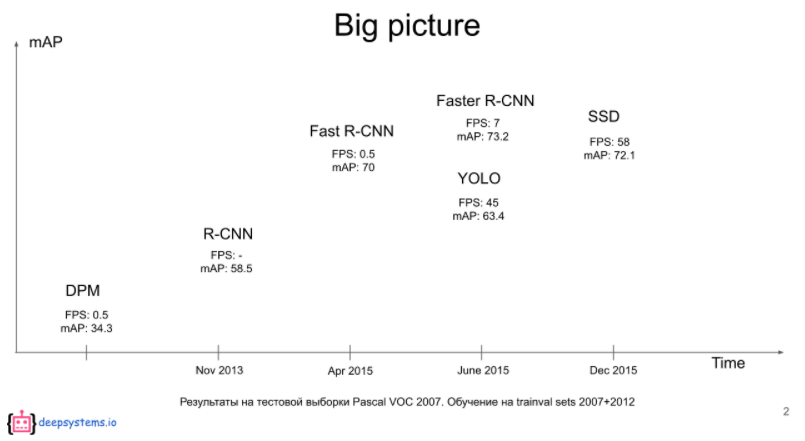

- One stage detection으로 정확도와 속도를 높임.
- YOLO는 속도 측면에서 당시 Faster R-CNN이 7FPS이었던 것을 45FPS까지 끌어올렸으나 정확도는 떨어졌다. 또 작은 물체를 잘 감지 못하는 단점도 있었다. 이런 문제를 해결하고자 하는 시도에서 출발한 것이 SSD이다.
    - Faster R-CNN: 7 FPS, 73.2% mAP
    - YOLO: 45 FPS, 63.4% mAP
    - SSD: 59 FPS, 74.3% mAP
    - Pascal VOC 2007 테스트 데이터 기준
    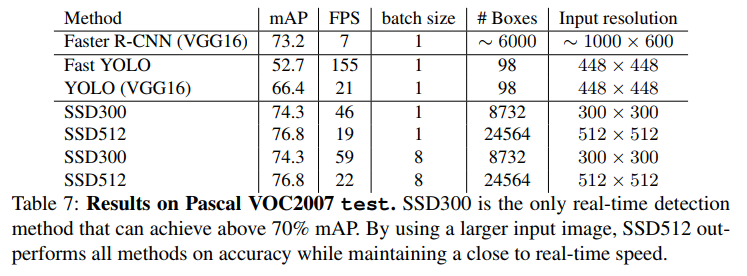
<br>
- ssd는 이후 one stage detection 알고리즘들이 ssd의 구조를 따라가면서 성능을 높이는데 집중함. (YOLO 제외)

- ### Single Shot MultiBox Detector
    - Single Shot Detector
        - one stage detection으로 input이 들어가 detection 하는 전과정을 한번에 처리한다.
        - 이것을 통해 빠른 속도의 검출이 가능하다.
    - MultiBox 
        - Multi-scale feature maps for detection
        - 다양한 크기의 feature map을 이용해 detection 하여 큰 물체와 작은 물체를 잘 detection하도록 한다.
        - 이것을 통해 Detection의 정확도를 높였다.

## Network(Model 구조) 와 Multi Scale Feature Maps for Detection

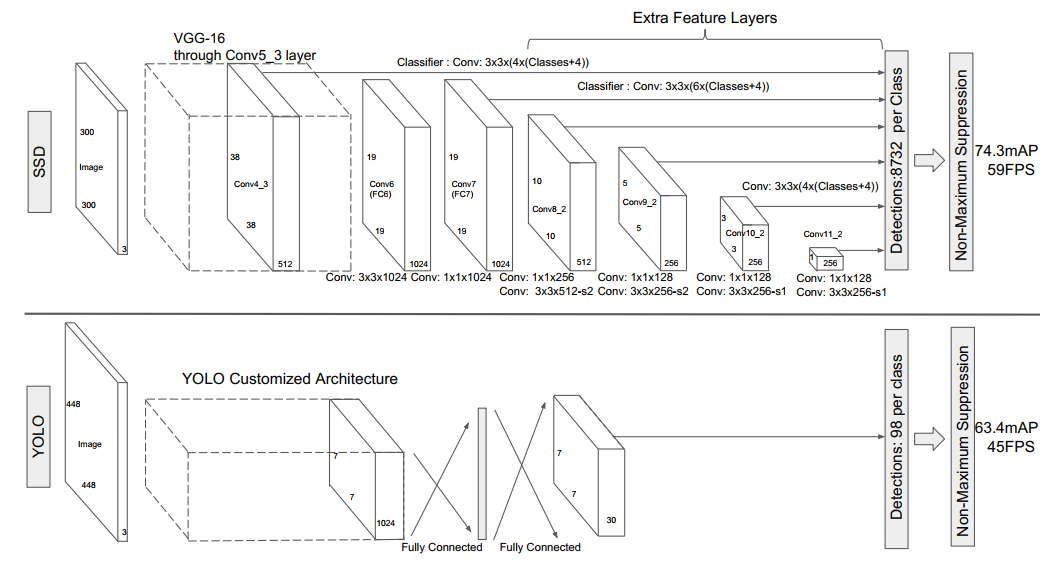

- Input image로 300 X 300 이미지를 사용 (SSD 300, SSD 512는 512 x 512 이미지사용)
- Base network로 VGG-16(conv5_3까지만 사용)을 사용.
    - Imagenet 데이터셋으로 pretrain.
    - 38 x 38 x 512 Feature map을 추출한다.
- Base network 이후 6개의 Convolution Layer(보조네트워크)를 사용해 Feature map을 추출하고 각 Feature map마다 Object Detection을 실행.
- 각 Feature map을 3 x 3 x **N**의 convolution layer를 통과 시켜 x,y,w,h 의 bounding box 위치와 detection할 클래스별 확률(Softmax)을 검출한다.
    - **N** : Default box개수 * (class별 확률 + boundingbox위치)
        - <a href='#Default-Boxes-Generating'>Default box</a>개수는 4, 또는 6
        - class별 확률: Pascal VOC dataset 사용. 20 + 1. 1은 배경
        - boundingbox 위치: 4 (x, y, w, h)
- 모든 레이어를 통과하면 각 feature map들을 이용해 검출된 결과를 취합한 뒤 Non-Maximum Suppression을 이용해 최종 결과를 출력한다.   

### Multi Scale Feature Maps for Detection 흐름

- 다양한 size의 Feature map으로부터 객체를 검출하므로 다양한 크기의 object에 대한 검출 정확도가 더 높아진다.
    - Yolo는 7x7 하나의 grid에서 검출하지만 SSD는 전체 이미지를 38x38, 19x19, 10x10, 5x5, 3x3, 1x1의 그리드를 가진 Feature map들에서 물체를 검출한다.
    - Bottom 단 feature map에서는 작은 물체에 대한 검출이 top으로 갈 수록 큰 물체에 대한 검출이 이뤄진다.
    
    
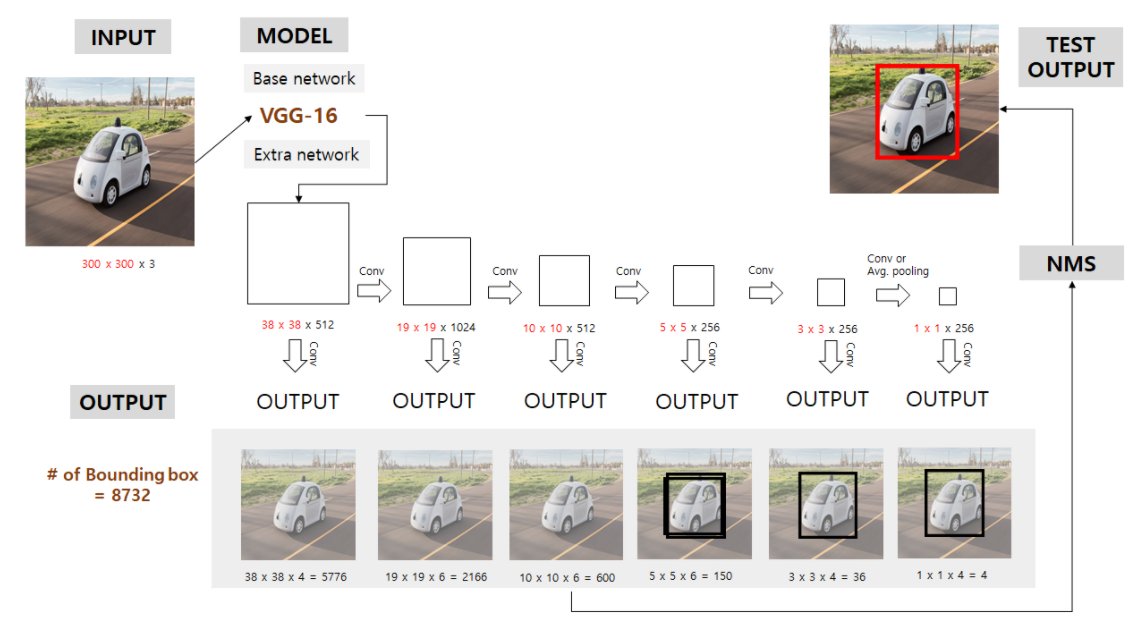

## Default Boxes Generating
- 비율과 크기가 다른 여러개의 Box들을 먼저 설정해놓고 그것을 이용해 Bounding Box를 추론한다.
    - 이 미리 정의된 box들을 Default Box라고 한다.
    - 다른 많은 모델에서는 Anchor라고 한다.'
- Feature map의 grid마다 N개(4 또는 6개)의 Default Box 물체를 검출한다. 
- Default Box
    - feature map 마다 서로 다른 크기(scale) 기준 다양한 종횡비(aspect ratio)의 default box를 이용해 물체를 검출한다.
> - scale : botton layer부터 추출한 feature map에 적용시킬 default box의 scale    
>     - 0.2, 0.34, 0.48, 0.62, 0.76, 0.9
> - 4개일때 width, height 비율
>     - 1:1, 1:2, 2:1, 1:1(더 큰 정사각형)
> - 6개일때 width, height 비율
>     - 1:1, 1:2, 1:3, 2:1, 3:1, 1:1(더 큰 정사각형)

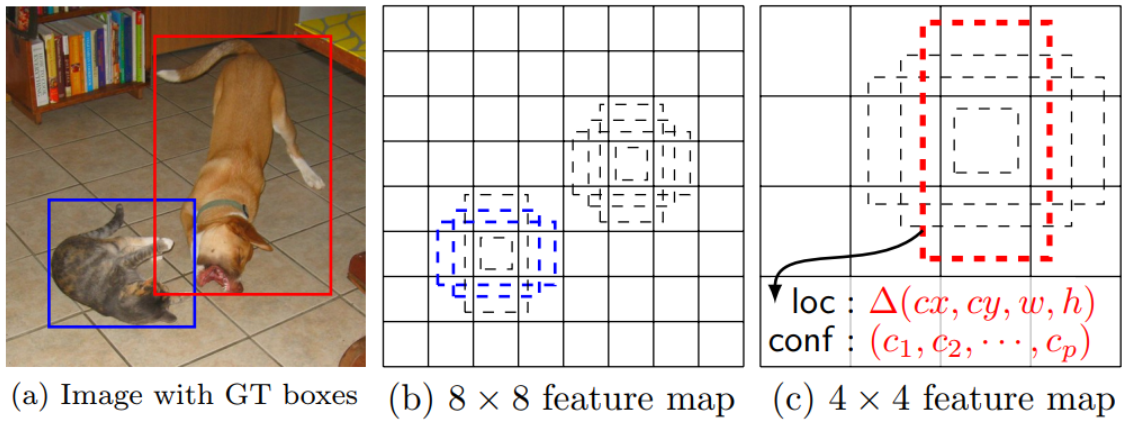

## Training

- SSD는 예측한 Bounding Box와 Ground truth Bounding Box 간의 IoU를 계산해 특정 Threshold를 넘으면(논문은 0.5) 일치한다고 가정하고 모두 학습한다.
    - 대부분의 모델들은 IoU가 가장큰 Bounding Box만 사용하는데 SSD는 특정 threshold보다 큰 상자들을 모두 선택하는 하여 모델이 높은 정확도를 가진 상자들을 많이 학습하게 하므로써 모델의 학습결과를 향상시킬 수 있다.
    
### Hard negative mining
 - 예측한 bounding box(default box) 맞는 것(positive samples)보다 틀린게(Negative samples)의 양이 훨씬 많게된다. (이미지 내에 object는 몇개 안되고 대부분이 배경이다.) 이 상태에서 train을 하게 되면 불균형 문제로 제대로 학습이 안되는 문제가 발생한다. 그래서 **추출된 default box의 classification loss(confidence loss)를 내림차순으로 정렬한 뒤 그중 positive의 3배 정도의 수량만 선택해서 train 시킨다.**(클수록 오차가 큰 것임). 이런 방식을 hard negative mining 이라고 한다. 
- positive sample: ground truth와 IoU가 지정한 threshold **이상인** default box
- negative sample: ground truth와 IoU가 지정한 threshold **미만인** default box
- positive : negative = 1 : 3 비율

### Loss Function
- multi-task loss
    - classification 예측 결과에 대한 오차로 cross entropy 를 사용한다.
    - bounding box의 좌표 예측에 대한 오차로 $smooth_{L1} loss$를 사용한다. 
    - 이 두개의 오차를 합쳐 최종 loss를 구한다.

> - $\large smooth_{L1} loss$
>    - 실제값과 예측값의 MSE를 구한다. 그 값이 1보다 작으면 제곱한 값에 0.5곱한 값(절반)을 1이상이면 그 값에서 0.5 뺀 값을 반환한다.
> 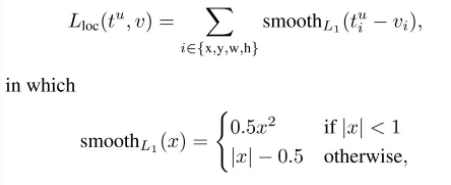

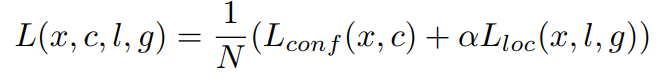



- N: Ground Truth와 IoU가 threshold 보다 크게 나온 default box의 개수. N이 0이면 loss를 0으로 설정.
- x: 실제 class
- c: 예측한 class
- l: 예측한 bounding box
- g: 실제 bounding box
- $\large L_{conf}(x,c)$: classification 오차. Cross Entropy 사용
- $\large\alpha L_{loc}(x,l,g)$: Localization - Bounding Box 예측 오차